In [84]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

#### Testing File Paths

In [85]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [86]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 1. Plot Wav

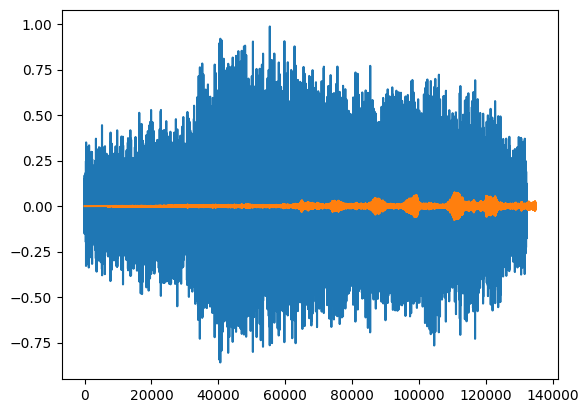

In [87]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 2. Create Tensorflow Dataset

In [88]:
# Define paths to Positive and Negative data
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
# Create Dataset
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')
# Add binary labels and Combine Positive and Negative Examples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

### Calculate average length of a bird call

In [89]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=149905>

# 3. Build Preprocessing Function to Convert to Spectrogram

Build Preprocessing Function to Convert to Spectrogram

In [173]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000] #take the first 48k values
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32) # calculate number of padding 0's needed
    wav = tf.concat([zero_padding, wav],0) # insert zeros at the begining

    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram) # convert negatives to positives
    spectrogram = tf.expand_dims(spectrogram, axis=2) # format 
    return spectrogram, label

### Check transofmation of data

In [174]:
# wav = load_wav_16k_mono(CAPUCHIN_FILE)
# wav = wav[:48000] 
# zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
# wav = tf.concat([zero_padding, wav],0)
# spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
# spectrogram = tf.abs(spectrogram) # convert negatives to positives
# spectrogram = tf.expand_dims(spectrogram, axis=2) # format 
# spectrogram

### Find Random File and display spectogram

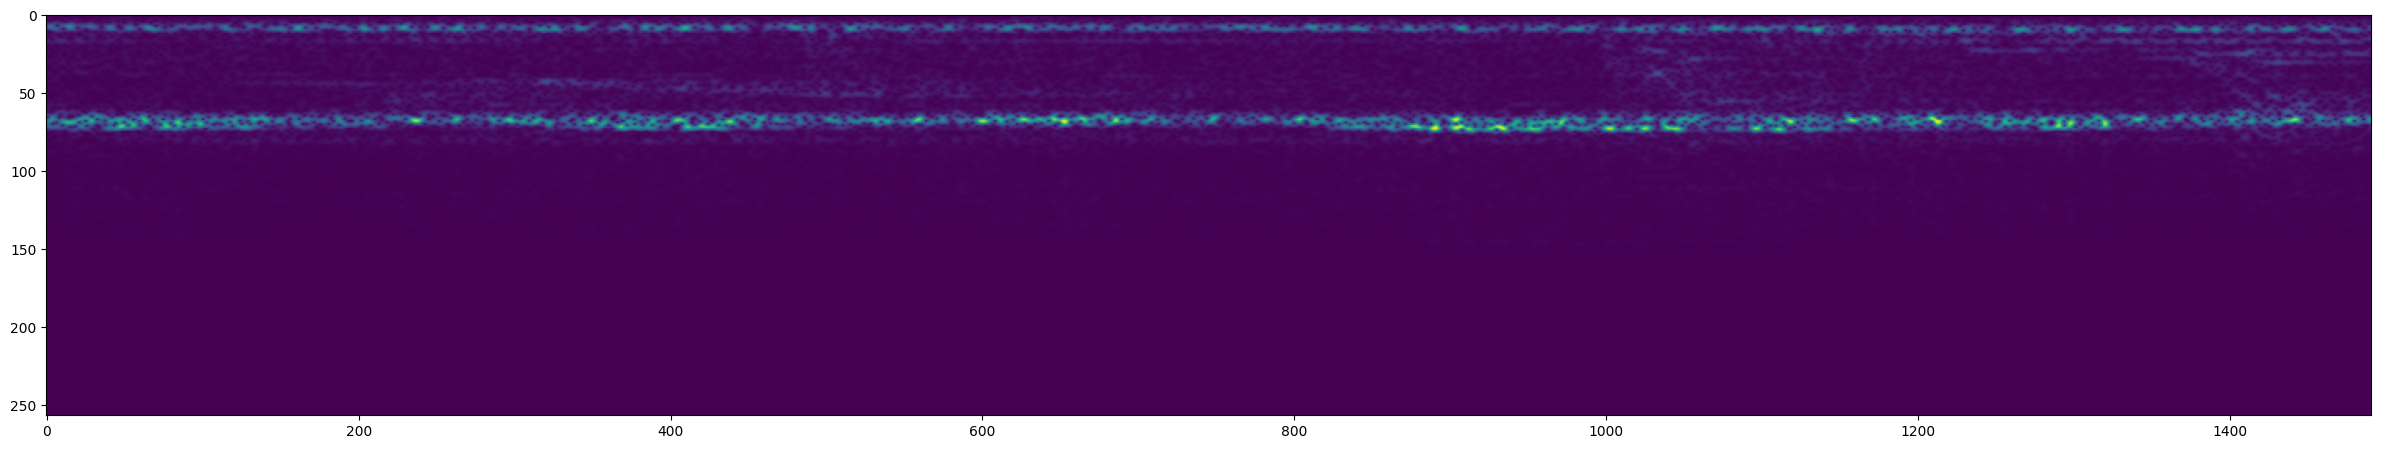

In [175]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next() # Gets random positive file from "Data"
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()